## Script LQG - Multijoint with forcefield


### Script LQG - 2 joint hand reach model


In [1]:
# define optimal feedback gain function    
def OFG(A1,B1,Q1,R1,x0,nStep1):
    ns1  = np.size(A1,0)
    nc1  = np.size(B1,1)
    n1   = np.size(Q1,2)
    S1   = Q1[:,:,-1]
    oXi1 = B1 @ (B1.T)
    L1   = np.zeros(((nc1, ns1, nStep1)))
    s1   = 0;
    
    for k1 in np.arange(n1-2,-1,-1):
        L1[:,:,k1] = np.linalg.solve((R1[:,:,k1] + B1.T @ S1 @ B1), (B1.T @ S1 @ A1 ) )
        St1        = S1[:]
        S1         = Q1[:,:,k1] + ( A1.T @ St1 @ (A1-(B1 @ L1[:,:,k1])))
        s1         = s1 + np.trace(St1+oXi1)
    return L1

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import warnings
warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'X-Y position in workspace')

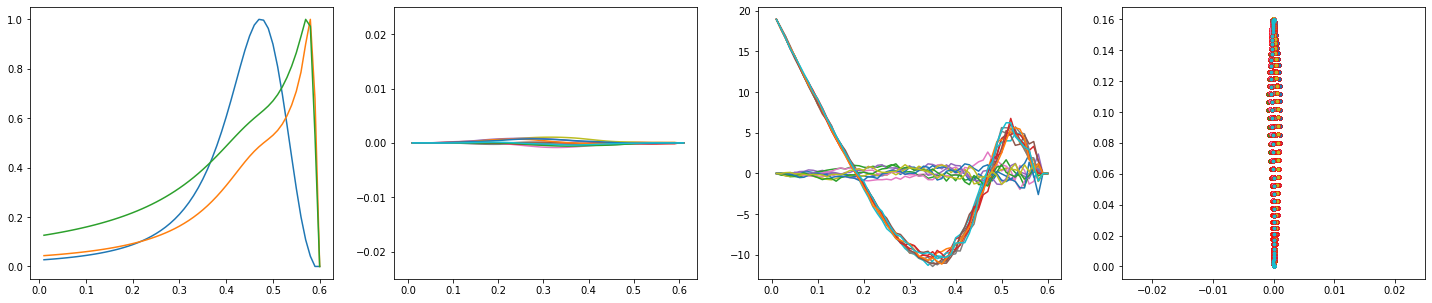

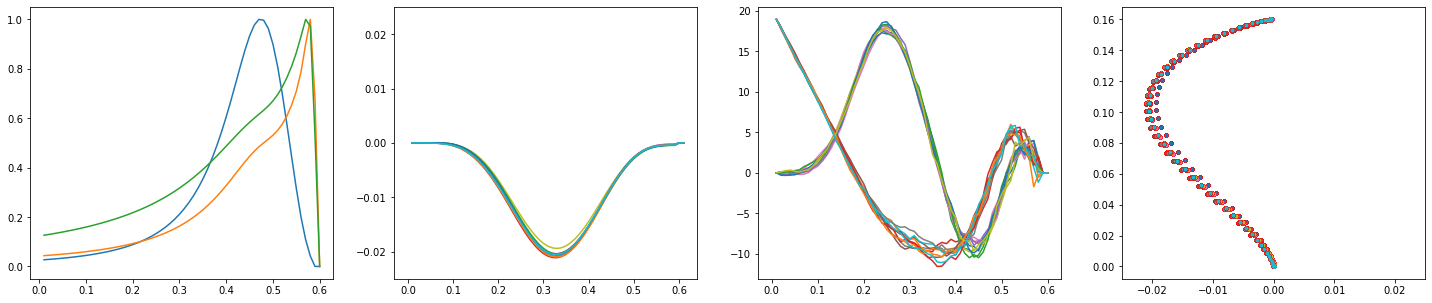

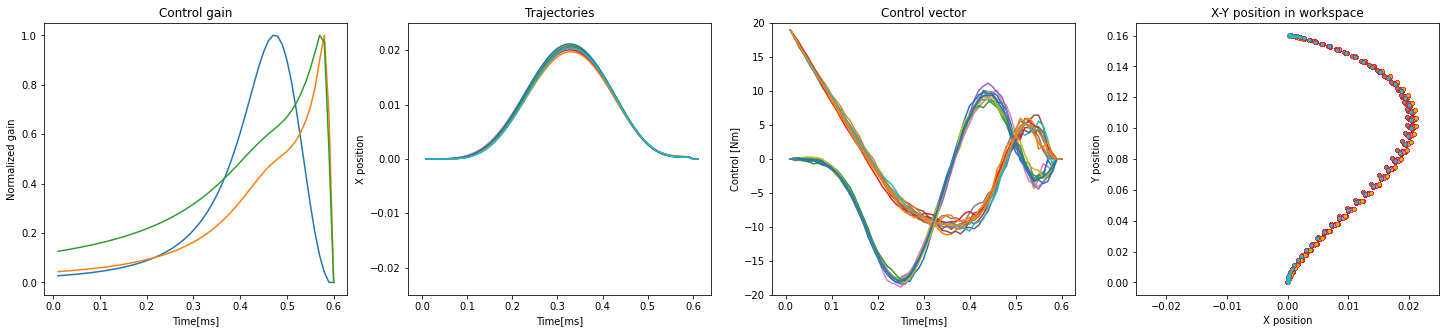

In [3]:
# Main script
load = np.array([0, -13, 13]) # possible mechanical perturbation loads
for Lo in load:
    gamma  = 0.5;
    rtime = 0.6 # 600 ms reach time 
    xinit  = np.array([[0], [0],[0] ,[0], [0], [0]]);
    xfinal = np.array([[0], [0.16], [0], [0], [0], [0]]);
    x0     = np.vstack((xinit,xfinal))    
    Gx     = 0.1;
    Gy     = 0.1;
    m      = 2.5;
    tau    = 0.1;
    lamda  = 0
    k      = 0
    
    A = np.array([[0,0,1,0,0,0],\
                  [0,0,0,1,0,0],\
                  [-k/m,0, -Gx/m, Lo/m, np.power(m,-1),0],\
                  [0, -k/m,0,-Gy/m,0,np.power(m,-1)],\
                  [0,0,0,0,np.power(-tau,-1),lamda/tau],\
                  [0,0,0,0,lamda/tau,np.power(-tau,-1)]])
    B = np.array([[0,0],\
                  [0,0],\
                  [0,0],\
                  [0,0],\
                  [np.power(tau,-1),lamda/tau],\
                  [lamda/tau,np.power(tau,-1)]])    
    
    ns  = np.size(A,0)
    nc  = np.size(B,1)
    
    # Transformation into discrete time system: Choose a numerical integration
    delta = 0.01
    A     = np.eye(ns)+delta*A
    B     = delta*B
    
    # Augment the system to include a target state:
    A         = np.vstack((np.hstack([A,np.zeros((ns,ns))]),\
                           np.hstack([np.zeros((ns,ns)),np.eye(ns)])))
    B         = np.vstack((B,np.zeros((ns,nc))))
    Aest      = copy.deepcopy(A)
    Aest[2,3] = 0; # Estimation without any perturbation
        
    # Define the cost-function
    # J(x,u) = sum x[k+1]Q[k+1]x[k+1] + u[k]R[k]u[k]
   
    nStep = int(rtime/delta)
    Q     = np.zeros(((2*ns,2*ns,nStep+1)))
    R     = np.zeros(((nc,nc,nStep)))
    #R    = np.power(10,-5*np.ones(((nc,nc,nStep)))
    for i in np.arange(nStep):
        R[:,:,i] = np.power(10.0,-5)*np.eye(nc)
    
    #Fill in the cost of the last target
    In = np.eye(ns)
    w  = np.array([1000, 1000, 20, 20,0,0]) # weights for position and velocity accuracy at end point
    for i in np.arange(ns):
        ei        = np.vstack((In[:,[i]], -In[:,[i]]))
        Q[:,:,-1] = Q[:,:,-1] + w[i]*ei @ (ei.T)
        
    for i in np.arange(nStep):
        Q[:,:,i] = np.power(((i+1)/nStep),25) * Q[:,:,-1] 
    
    # Backwards recurrence for the optimal feedback gains
    L     = OFG(Aest,B,Q,R,x0,nStep);
    L2    = copy.deepcopy(L)
    Q2    = copy.deepcopy(Q)
    A2    = copy.deepcopy(A)
    Aest2 = copy.deepcopy(Aest)
    gain  = np.zeros((6,nStep))
    
    # plot gains
    for k in np.arange(nStep):
        gain[0,k] = L[0,0,k]
        gain[2,k] = L[0,2,k]
        gain[4,k] = L[0,4,k]
       
    gain2      = np.zeros((6,nStep))
    gain2[0,:] = gain[0,:]/np.ndarray.max(gain[0,:])
    gain2[2,:] = gain[2,:]/np.ndarray.max(gain[2,:])
    gain2[4,:] = gain[4,:]/np.ndarray.max(gain[4,:])
    
    plt.figure(figsize=(25, 5))
    plt.subplot(141)
    plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), gain2[0,0:100])
    plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), gain2[2,0:100])
    plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), gain2[4,0:100])
    
    # forward recurrence for the optimal kalman gain
    H      = np.eye(2*ns)
    ny     = np.size(H,0)
    oXi    = B @ (B.T)
    oOmega = 0.5*np.ndarray.max(oXi)*np.eye(2*ns)
    Sigma  = oOmega[:]
    K      = np.zeros((2*ns,ny,nStep))
    
    for k in np.arange(nStep):
        K[:,:,k] = (A @ Sigma @ H.T) @ (np.linalg.inv (H @ Sigma @ H.T + oOmega))
        Sigma    = oXi + (A-K[:,:,k]@ H) @ (Sigma @ A.T)
        
    # Simulations
    nsimu      = 10                                # perform 10 simulation runs
    x          = np.zeros(((2*ns,nStep+1,nsimu)))  # initialize state
    xhat       = copy.deepcopy(x)                  # initialise state estimate
    control1   = np.zeros(((nc,nStep,nsimu)))
    control2   = np.zeros(((nc,nStep,nsimu)))
    avControl1 = np.zeros((nc,nStep))
    avControl2 = np.zeros((nc,nStep))
    
    for p in np.arange(nsimu):
        x[:,0,p]    = (np.vstack((xinit,xfinal))).T
        xhat[:,0,p] = (np.vstack((xinit,xfinal))).T
        L           = copy.deepcopy(L2)
        Q           = copy.deepcopy(Q2) 
        A           = copy.deepcopy(A2)
        Aest        = copy.deepcopy(Aest2)
        
        for k in np.arange(nStep-2):
            motorNoise     = np.random.multivariate_normal(np.zeros(2*ns),oXi)
            sensorynoise   = np.random.multivariate_normal(np.zeros(2*ns),oOmega)
            u              = -L[:,:,0] @ x[:,k,p]
            L              = OFG(Aest,B,Q[:,:,k+1:],R[:,:,k+1:],xhat[:,k,p],nStep)
            #print(u)
            x[:,k+1,p]     = (A @ x[:,k,p]) + (B @ u) + motorNoise
            xhat[:,k+1,p]  = (Aest @ x[:,k,p]) + (B @ u)
           
            eps1           = x[:ns,k+1,p]-xhat[:ns,k+1,p]
            # updating model matrices
            theta_t   = Aest[2,3]
            psy       = np.zeros((ns))
            psy[2]    = x[3,k+1,p];
            theta_up  = theta_t +gamma * psy @ eps1.reshape(-1, 1)
            Aest[2,3] = theta_up[0]
            
            control1[:,k,p] = u[0]
            control2[:,k,p] = u[1]
            
            plt.subplot(142)
            plt.plot(k*0.01, x[0,k,p])
                       
            plt.subplot(143)
            plt.plot(k*0.01, control1[0,k,p])
            plt.plot(k*0.01, control2[0,k,p])
                    
            plt.subplot(144)
            plt.plot(x[0,:,p],x[1,:,p],'.r')
            
        avControl1 = avControl1 +control1[:,:,p]/nsimu
        avControl2 = avControl2 +control2[:,:,p]/nsimu
        
        plt.subplot(142)
        plt.ylim(-0.025,0.025)
        plt.plot(np.arange(0.01,(nStep+2)*0.01,0.01), x[0,:,p])
     
        plt.subplot(143)
        plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), control1[0,:,p])
        plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), control2[0,:,p])
           
        plt.subplot(144)
        plt.xlim(-0.025,0.025)
        plt.plot(x[0,:,p],x[1,:,p],'.')
        
plt.subplot(143)
plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), avControl1[0,:])
plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), avControl2[0,:])
plt.ylim(-20,20)
plt.xlabel('Time[ms]');plt.ylabel('Control [Nm]');plt.title('Control vector')

plt.subplot(141)
plt.xlabel('Time[ms]');plt.ylabel('Normalized gain');plt.title('Control gain')

plt.subplot(142)
plt.ylim(-0.025,0.025)
plt.xlabel('Time[ms]');plt.ylabel('X position');plt.title('Trajectories')

plt.subplot(144)
plt.xlim(-0.025,0.025)
plt.xlabel('X position');plt.ylabel('Y position');plt.title('X-Y position in workspace')